## A Simple Example for Training with Attribution Priors
This notebook is an example notebook for how to train with attribution priors. It defines some very simple, simulated data, and trains a small neural network to learn from that data. In the process, it shows how to regularize the neural network not to look at a specific feature using attribution priors. Although this particular example is very simple, attribution priors can be extended to more complex and useful penalties.

In [1]:
import tensorflow as tf
import numpy as np
import shap
import pandas as pd
import altair as alt
import scipy.stats as stats
from attributionpriors.ops import AttributionPriorExplainer

### First we need to generate some random data to learn from
- The data will have 1000 samples and 3 features.
- The outcome $y$ will be continuous, $y = x_{0} - x_{1} + \epsilon$ where $\epsilon \sim N(0, 0.5)$
- The 3rd feature $x_{2}$ is a dummy feature, $x_2 = x_0 + N(0, 0.5)$

In [2]:
#Generate some random features
feature_mean = 0.0
feature_sigma = 1.0
N = 1000
d = 3
X = np.random.randn(N, d) * feature_sigma + feature_mean
X[:, 2] = X[:, 0] + np.random.randn(N) * 0.5

In [3]:
outcome_mean = 0.0
outcome_sigma = 0.5
Y = X[:, 0] - X[:, 1] + np.random.randn(N) * outcome_sigma + outcome_mean
Y = np.reshape(Y, (1000, 1))

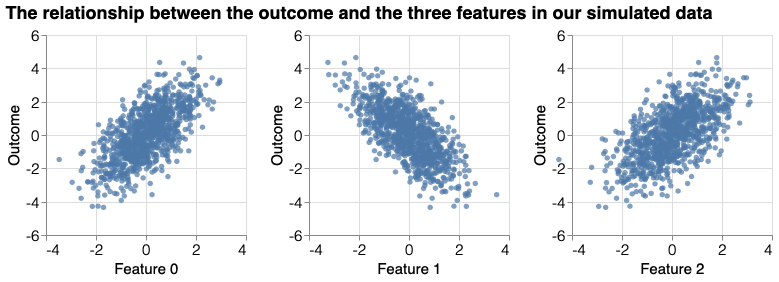

In [4]:
data = pd.DataFrame({'Feature 0': X[:, 0], 'Feature 1': X[:, 1], 'Feature 2': X[:, 2], 'Outcome': Y.squeeze()})
alt.Chart(data).mark_point(filled=True).encode(
    x=alt.X(alt.repeat('column'), type='quantitative', scale=alt.Scale(domain=[-4, 4])),
    y=alt.Y('Outcome:Q', scale=alt.Scale(domain=[-6, 6]))
).properties(
    height=200,
    width=200
).repeat(
    column=['Feature 0', 'Feature 1', 'Feature 2']
).properties(
    title='The relationship between the outcome and the three features in our simulated data'
).configure_axis(
    labelFontSize=15,
    labelFontWeight=alt.FontWeight('lighter'),
    titleFontSize=15,
    titleFontWeight=alt.FontWeight('normal')
).configure_title(
    fontSize=18
)

## Data Splits + Data API
Now we have some code to split the data into different chunks, and read it in.

In [5]:
def make_dataset(X, Y, batch_size, shuffle=True, buffer_size=100):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    return dataset

In [6]:
index_order = np.random.permutation(N)
indices_train = index_order[:800]
indices_vald  = index_order[800:900]
indices_test  = index_order[900:]

batch_size=20
train_set = make_dataset(X[indices_train, :], Y[indices_train], batch_size=batch_size, shuffle=True, buffer_size=800)
train_set = train_set.repeat(15)
vald_set  = make_dataset(X[indices_vald, :],  Y[indices_vald],  batch_size=100, shuffle=False)
test_set  = make_dataset(X[indices_test, :],  Y[indices_test],  batch_size=100, shuffle=False)

In [7]:
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(
    handle, train_set.output_types, train_set.output_shapes)
x_pl, y_true = iterator.get_next()

In [8]:
train_iter = train_set.make_initializable_iterator()
vald_iter  = vald_set.make_initializable_iterator()
test_iter  = test_set.make_initializable_iterator()

In [9]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [10]:
train_handle = sess.run(train_iter.string_handle())
vald_handle  = sess.run(vald_iter.string_handle())
test_handle  = sess.run(test_iter.string_handle())

## Now lets build a model
We will use a simple neural network with one hidden layer, and 5 hidden units.

In [11]:
def model(x_pl):
    hidden_units = tf.layers.Dense(5, activation=tf.nn.relu, use_bias=True)(x_pl)
    output = tf.layers.Dense(1, activation=None, use_bias=False)(hidden_units)
    return output

In [12]:
def logits_accuracy(labels, logits):
    correct_prediction = tf.equal(tf.cast(tf.argmax(logits, 1), tf.int32), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

We use the API provided by wrapping our input using an `AttributionPriorExplainer` object, as explained
in the README file of this repository.

In [13]:
explainer = AttributionPriorExplainer()
cond_input_op, train_eg = explainer.input_to_samples_delta(x_pl)
y_pred = model(cond_input_op)

In [14]:
expected_grads_op = explainer.shap_value_op(y_pred, cond_input_op, tf.squeeze(y_true))

We can verify that our expected gradients operation is the same shape
as our input, because it should provide attributions for each feature in each batch.

In [15]:
expected_grads_op

<tf.Tensor 'expected_grads:0' shape=(?, 3) dtype=float64>

## Losses
We will use our standard mean squared error on the labels. As an attribution prior, we also penalize the squared
magnitude of feature importance on the last feature. This will encourage our model not to use that last feature, which we know is a dummy feature.

In [16]:
mse_op = tf.losses.mean_squared_error(y_true, y_pred)
train_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(mse_op)

In [17]:
weights = np.array([0.0, 0.0, 1.0]).reshape(3, 1)
tf_weights = tf.constant(weights, dtype=tf.float32)
weighted_squared_loss = tf.matmul(tf.square(tf.cast(expected_grads_op, tf.float32)), tf_weights)
weighted_squared_loss = tf.squeeze(weighted_squared_loss, axis=1)
mean_weighted_squared_loss = tf.reduce_mean(weighted_squared_loss, name='mean_weighted_squared_loss')

reg_lambda = tf.constant(30.0, dtype=tf.float32)
reg_loss_op   = mean_weighted_squared_loss * reg_lambda

train_eg_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(reg_loss_op)

In [38]:
def train(use_ap):
    sess.run(tf.global_variables_initializer())
    sess.run(train_iter.initializer)
    #One pass through the data:
    i = 0
    steps = []
    validation_losses = []
    while True:
        try:
            batch_input, batch_labels, _ = sess.run([cond_input_op, y_true, train_op], feed_dict={handle: train_handle})
            if use_ap:
                sess.run(train_eg_op, feed_dict={handle: train_handle, 
                                                 train_eg: True,
                                                 x_pl: batch_input,
                                                 y_true: batch_labels})
            i += 1
            if i % 10 == 0:
                sess.run(vald_iter.initializer)
                vald_loss = sess.run(mse_op, feed_dict={handle: vald_handle})
                validation_losses.append(vald_loss)
                steps.append(i)
        except tf.errors.OutOfRangeError:
            break
            
    sess.run(test_iter.initializer)
    test_loss= sess.run(mse_op, feed_dict={handle: test_handle})
    
    print('Test MSE: {:.4f}'.format(test_loss))
    explainer = shap.GradientExplainer((cond_input_op, y_pred), X, sess)
    shap_values = explainer.shap_values(X, nsamples=200)
    shap.summary_plot(shap_values[0], X)
    
    sess.run(test_iter.initializer)
    y_pred_test, y_true_test = sess.run([y_pred, y_true], feed_dict = {handle: test_handle})
    
    data = pd.DataFrame({
        'Iteration': steps,
        'Validation Loss': validation_losses
    })
    return alt.Chart(data).mark_line().encode(alt.X('Iteration:Q'), alt.Y('Validation Loss:Q', scale=alt.Scale(domain=[0.0, 2.5])))

## Training without an attribution prior
First, we train without an attribution prior. The neural network mostly focuses on $x_0$ and $x_1$, but it also uses $x_2$ to make predictions, even though all the information contained in $x_2$ is already contained in $x_0$. We visualize the feature importances using the SHAP package.

Test MSE: 0.2576


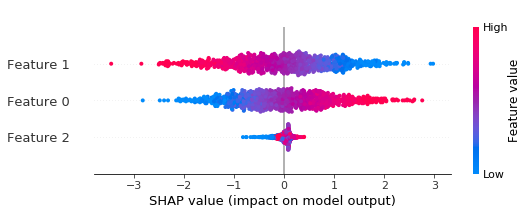

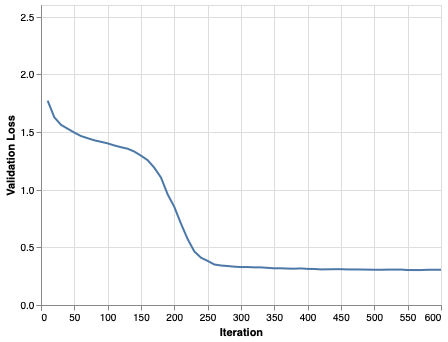

In [39]:
train(use_ap=False)

## Training with an attribution prior
Now we train with an attribution prior that pushes the model not to use $x_2$. In this case, the model no longer relies on $x_2$ and performs as well if not better than the previous model.

Test MSE: 0.2378


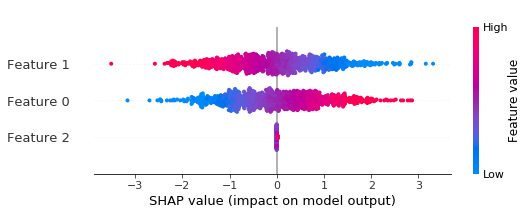

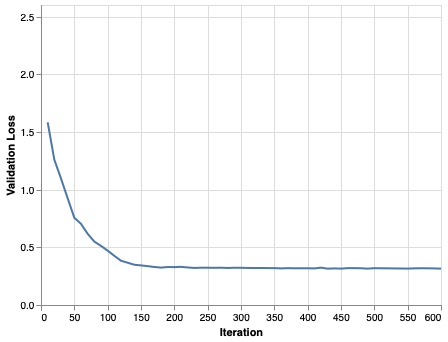

In [40]:
train(use_ap=True)

## Close the session
Don't forget to close the TensorFlow session when we are done!

In [21]:
sess.close()